In [117]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import os
from scipy import io

In [225]:
def read_mtx_folder(folder_path, sample_name):
    counts = io.mmread(os.path.join(folder_path, 'matrix.mtx')).T.tocsr()
    barcodes = pd.read_csv(os.path.join(folder_path, 'barcodes.tsv'), header=None, sep='\t')[0].values
    features = pd.read_csv(os.path.join(folder_path, 'features.tsv'), header=None, sep='\t')[1].values
    adata = ad.AnnData(
        counts,
        obs=pd.DataFrame(index=[f"{sample_name}_{x}" for x in barcodes]),
        var=pd.DataFrame(index=features)
    )
    adata.obs['sample'] = sample_name
    adata.var_names_make_unique()
    return adata

In [226]:
os.chdir(r'D:\westlakeData\single-cell analysis\CC')

In [227]:
tumor_adata=read_mtx_folder('Tumor','Tumor')
nor_adata=read_mtx_folder('Normal','Normal')

D:\Anaconda5.3.1\envs\scpy\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\Anaconda5.3.1\envs\scpy\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [228]:
adata=nor_adata.concatenate(tumor_adata,join='outer')
adata

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13764\3761219229.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata=nor_adata.concatenate(tumor_adata,join='outer')


AnnData object with n_obs × n_vars = 25642 × 33694
    obs: 'sample', 'batch'

In [229]:
if 'mt' not in adata.var.columns:
    adata.var['mt'] = adata.var_names.str.startswith(('MT-', 'mt-'))
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
adata

AnnData object with n_obs × n_vars = 25642 × 33694
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

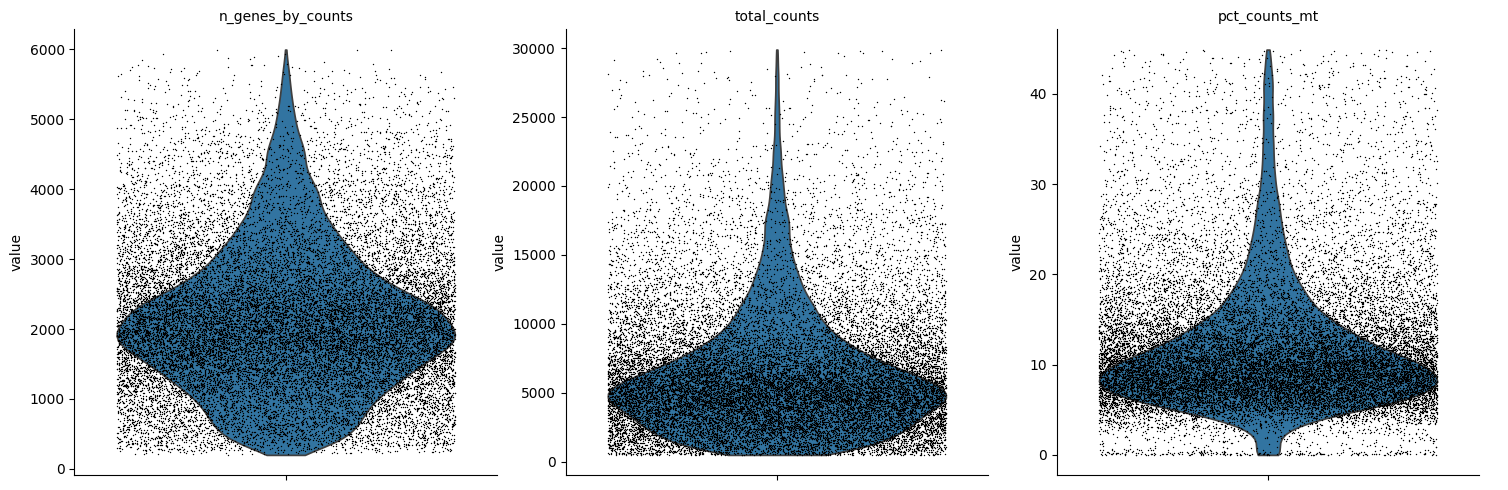

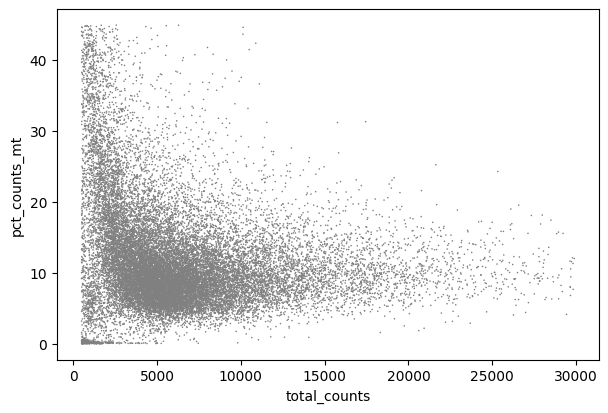

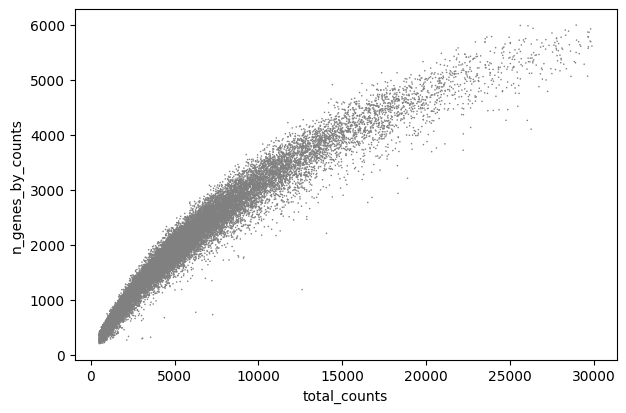

In [116]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [230]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 25, :].copy()
adata = adata[adata.obs['total_counts'] <= 30000, :].copy()
adata

AnnData object with n_obs × n_vars = 22151 × 33694
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 29.7%
Overall doublet rate:
	Expected   = 3.0%
	Estimated  = 0.0%
Elapsed time: 50.1 seconds


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

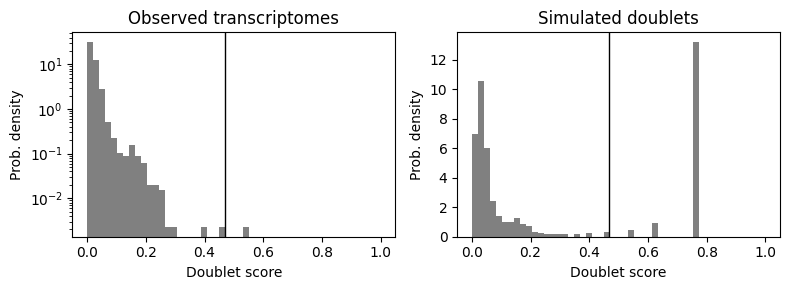

In [231]:
import scrublet as scr
scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.03)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata.obs['doublet_score'] = doublet_scores
adata.obs['predicted_doublets'] = predicted_doublets
scrub.plot_histogram()
#plt.show()

In [233]:
def preprocess_fast(
    sdata1,
    min_genes=200,
    min_cells=3,
    mode='customized',
    target_sum=1e4,
    base=2,
    zero_center=True,
    regressout=False,
    force_dense=False
):
    import scipy.sparse
    sdata1 = sdata1.copy() if not isinstance(sdata1, ad.AnnData) else sdata1
    if 'raw' not in sdata1.layers:
        sdata1.layers['raw'] = sdata1.X.copy()
    sdata1.raw = ad.AnnData(
        X=sdata1.layers['raw'],
        var=sdata1.var.copy(),
        obs=sdata1.obs.copy()
    )
    sc.pp.filter_cells(sdata1, min_genes=min_genes)
    sc.pp.filter_genes(sdata1, min_cells=min_cells)
    target_sum_str = '1e4' if target_sum == 1e4 else str(target_sum)
    if mode not in ['default', 'customized']:
        raise ValueError('模式必须是 "default" 或 "customized"')
    norm_data = sc.pp.normalize_total(sdata1, target_sum=target_sum, copy=True).X
    sdata1.layers[f'norm{target_sum_str}'] = norm_data.tocsr()
    sdata1.X = norm_data

    if scipy.sparse.issparse(sdata1.X):
        sdata1.X = sdata1.X.log1p() / np.log(base)
    else:
         sdata1.X = np.log1p(sdata1.X) / np.log(base)
    sdata1.layers[f'log{base}_norm{target_sum_str}'] = sdata1.X.copy()

    if scipy.sparse.issparse(sdata1.X) and not force_dense:
        scaled_data = sdata1.X.toarray()
        scaled_data = (scaled_data - scaled_data.mean(axis=0)) / scaled_data.std(axis=0)
        sdata1.layers[f'scaled_log{base}_norm{target_sum_str}'] = scaled_data
    else:
        sc.pp.scale(sdata1, zero_center=zero_center)
        sdata1.layers[f'scaled_log{base}_norm{target_sum_str}'] = sdata1.X.copy()

    if regressout:
        if 'total_counts' not in sdata1.obs:
            sdata1.obs['total_counts'] = np.array(sdata1.layers['raw'].sum(axis=1)).flatten()
        sc.pp.regress_out(sdata1, ['total_counts'])
        sdata1.layers[f'regressed_scaled_log{base}_norm{target_sum_str}'] = sdata1.X.copy()

    return sdata1

In [234]:
def combat_Harmony_integration(
    sdata_inte,
    batch_key,
    umap_n_neighbors=15,
    umap_n_pcs=50,
    scaled_layer='scaled_log2_norm1e4',
    use_highly_variable_t=True,
    n_components=50,
    ifpca=True,
    ifcombat=True,
    ifharmony=True,
    mode='sc',
    force_dense=False,
):
    import scipy.sparse
    import warnings
    if scaled_layer not in sdata_inte.layers:
        raise ValueError(f"层 {scaled_layer} 不存在，请检查输入！")
    sdata_inte.X = sdata_inte.layers[scaled_layer].copy()
    if ifcombat:
        if scipy.sparse.issparse(sdata_inte.X) and not force_dense:
            warnings.warn("ComBat 需要密集矩阵，正在自动转换（设置 force_dense=True 以禁用警告）")
            sdata_inte.X = sdata_inte.X.toarray()
        print("Running ComBat integration...")
        sc.pp.combat(sdata_inte, key=batch_key)
    if use_highly_variable_t:
        current_X = sdata_inte.X.copy()
        if 'raw' in sdata_inte.layers:
            sdata_inte.X = sdata_inte.layers['raw'].copy()
        sc.pp.highly_variable_genes(
            sdata_inte,
            n_top_genes=3000,
            flavor='seurat_v3',
            batch_key=batch_key
        )
        sdata_inte.var['highly_variable'] = sdata_inte.var['highly_variable'].astype(bool)  # 确保是布尔值
        sdata_inte.X = current_X
    if ifpca or ifharmony:
        print("Running PCA...")
        if mode == 'sc':
            sc.tl.pca(
                sdata_inte,
                mask_var="highly_variable" if use_highly_variable_t else None,  # 使用新参数
                svd_solver='full',
                n_comps=n_components
            )
        else:
            import rapids_singlecell as rsc
            rsc.pp.pca(sdata_inte, mask_var="highly_variable" if use_highly_variable_t else None, n_comps=n_components)
    if ifharmony:
        print("Running Harmony integration...")
        if mode == 'sc':
            sc.external.pp.harmony_integrate(sdata_inte, batch_key)
        else:
            rsc.pp.harmony_integrate(sdata_inte, batch_key)
        pc_feature = 'X_pca_harmony'
    else:
        pc_feature = 'X_pca'
    print("Computing neighborhood graph...")
    if mode == 'sc':
        sc.pp.neighbors(sdata_inte, n_neighbors=umap_n_neighbors, n_pcs=umap_n_pcs, use_rep=pc_feature)
    else:
        rsc.pp.neighbors(sdata_inte, n_neighbors=umap_n_neighbors, n_pcs=umap_n_pcs, use_rep=pc_feature)
    return sdata_inte

In [235]:
preprocess_fast(adata)

AnnData object with n_obs × n_vars = 22119 × 22299
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublets', 'predicted_doublet_manual', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    layers: 'raw', 'norm1e4', 'log2_norm1e4', 'scaled_log2_norm1e4'

In [236]:
combat_Harmony_integration(adata,'sample',50,30, 'scaled_log2_norm1e4',True,50,True,False,True)

Running PCA...


2025-08-01 15:11:02,130 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony integration...


2025-08-01 15:11:03,586 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-01 15:11:03,663 - harmonypy - INFO - Iteration 1 of 10
2025-08-01 15:11:07,014 - harmonypy - INFO - Iteration 2 of 10
2025-08-01 15:11:10,099 - harmonypy - INFO - Iteration 3 of 10
2025-08-01 15:11:13,208 - harmonypy - INFO - Iteration 4 of 10
2025-08-01 15:11:16,298 - harmonypy - INFO - Converged after 4 iterations


Computing neighborhood graph...


AnnData object with n_obs × n_vars = 22119 × 22299
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublets', 'predicted_doublet_manual', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'raw', 'norm1e4', 'log2_norm1e4', 'scaled_log2_norm1e4'
    obsp: 'distances', 'connectivities'

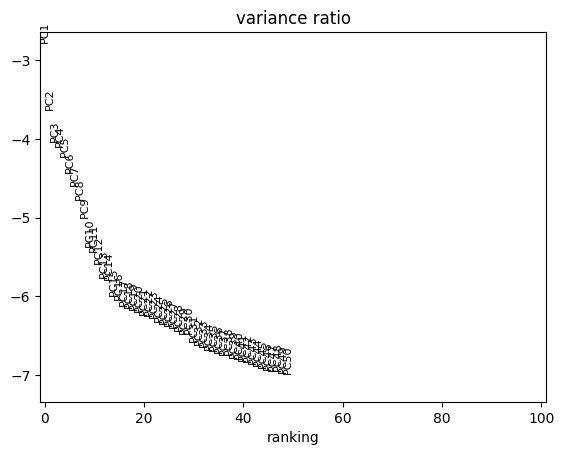

In [237]:
sc.pl.pca_variance_ratio(
    adata, 
    log=True,  
    n_pcs=100 
)

In [238]:
sc.tl.tsne(
    adata,
    perplexity=100
)
sc.tl.leiden(
    adata,
    resolution=1,
)

In [ ]:
adata = adata[~adata.obs['predicted_doublet_manual'], :].copy()
adata

<Figure size 4800x3600 with 0 Axes>

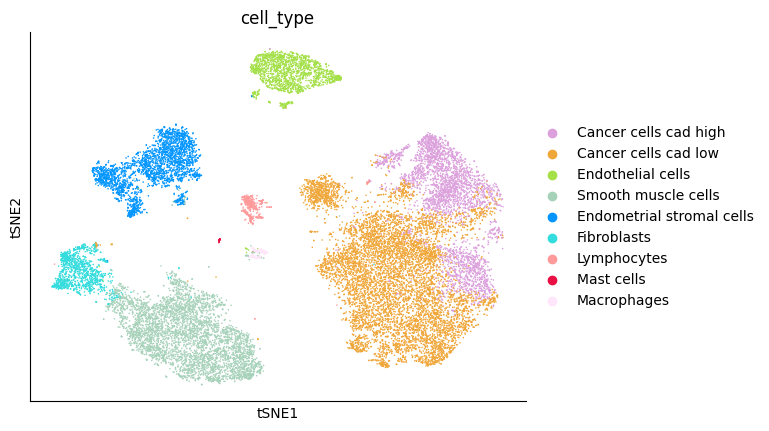

In [266]:
plt.figure(figsize=(8, 6), dpi=600)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.dpi'] = 600
if 'leiden_colors' in adata.uns:
    del adata.uns['leiden_colors']
ax = sc.pl.tsne(
    adata,
    color=['cell_type'],
    show=False,
    size=5,
    alpha=1,
    linewidth=0.3,
    #legend_fontsize=7.5,
    use_raw=False,
    #legend_loc='on data',
    vmax=1,
    cmap='Reds',
    ncols=2
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.tight_layout()
plt.savefig('cell_type_tsne.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [267]:
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    use_raw=False,
    corr_method='benjamini-hochberg',
    key_added='diff_genes'
)

D:\Anaconda5.3.1\envs\scpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
D:\Anaconda5.3.1\envs\scpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
D:\Anaconda5.3.1\envs\scpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
D:\Anaconda5.3.1\envs\scpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
D:\Anaconda5.3.1\envs\scpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
D:\Anaconda5.3.1\envs\scpy\Lib\site-packages\scanpy\too

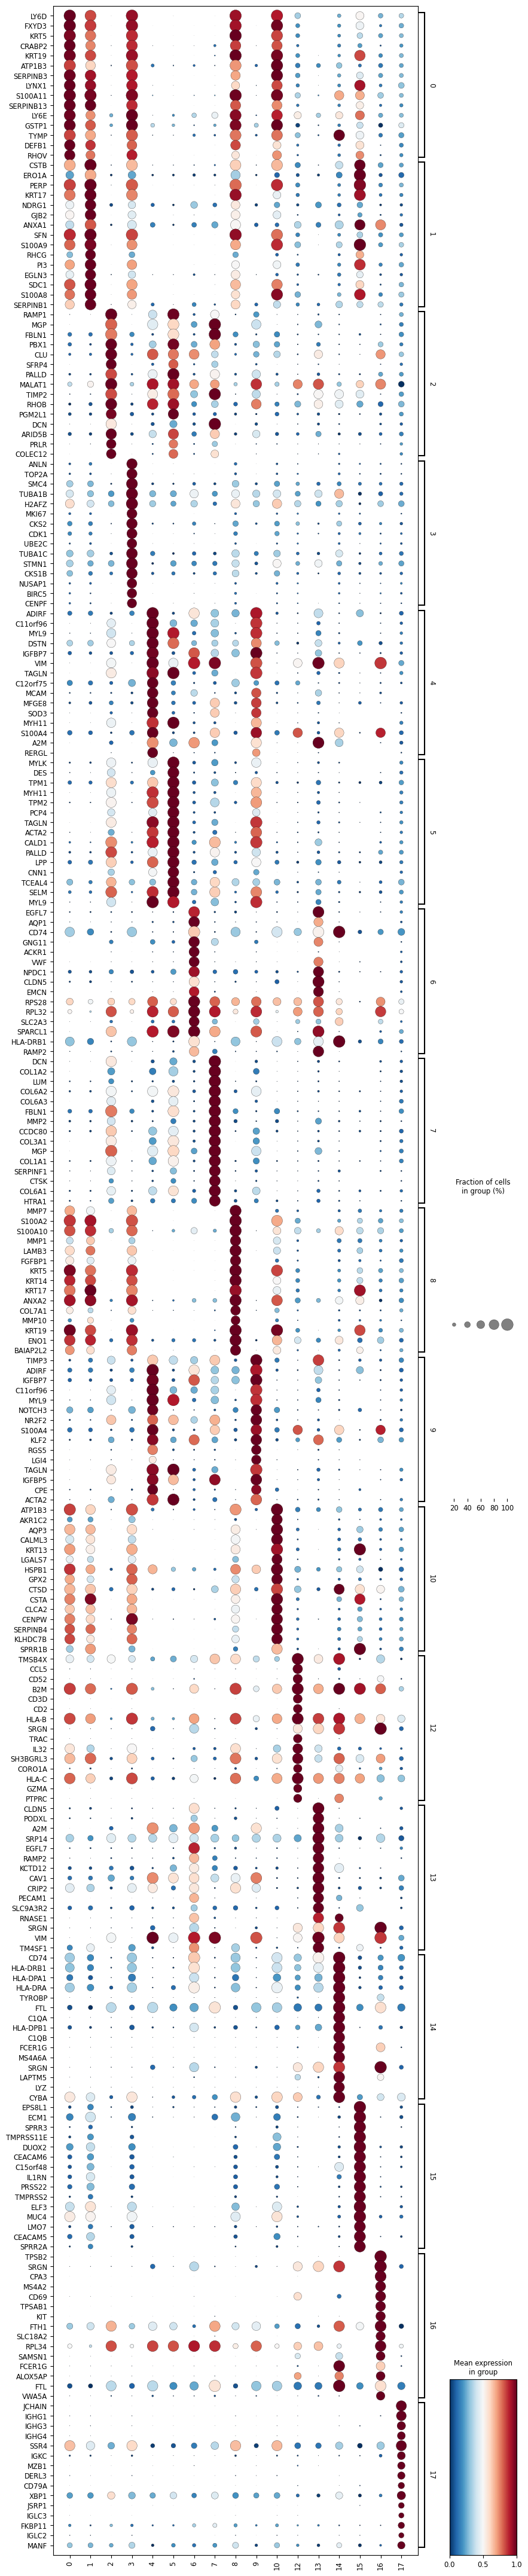

In [268]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby='leiden',
    key='diff_genes',
    n_genes=15,
    cmap='RdBu_r',
    standard_scale='var',
    swap_axes=True,
    dendrogram=False,
    figsize=(10, 55),
    use_raw=False,
)

In [ ]:
filter_mask = adata.obs['leiden'] != '11'
adata = adata[filter_mask, :].copy()
adata

In [193]:
markers_genes = {
    "Cancer cells": ["CDH1", "EPCAM", "CDKN2A"],
    "Endothelial cells": ['EGFL7','EMCN','PECAM1'],
    'Smooth muscle cells':["ACTG2"],
    'Endometrial stromal cells':['SUSD2'],
    'Fibroblasts': ['COL1A2','APOD'],
    "Lymphocytes": ["CD27","PRF1"],
    'Mast cells':["TPSAB1","CPA3"],
    "Macrophages": ['CD163','FCGR2A'],
}

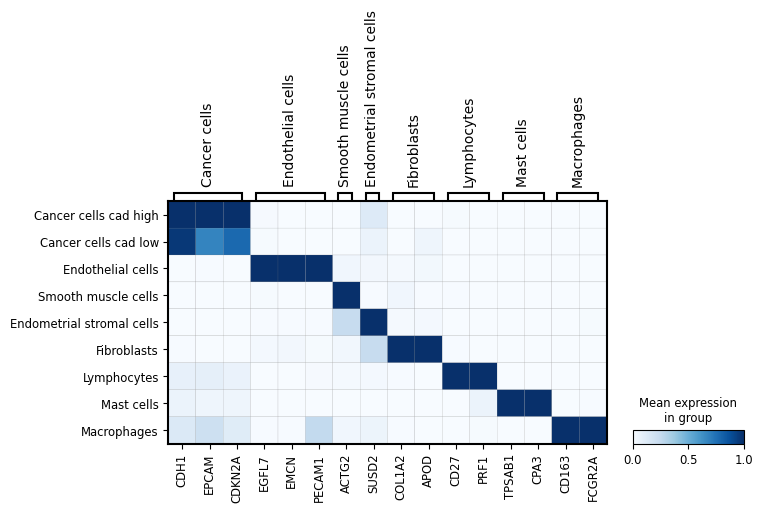

In [263]:
cell_type_list=['Cancer cells cad high','Cancer cells cad low','Endothelial cells','Smooth muscle cells','Endometrial stromal cells','Fibroblasts','Lymphocytes','Mast cells','Macrophages']
fig=sc.pl.matrixplot(
    adata,
    markers_genes,
    "cell_type",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    return_fig=True,
    categories_order=cell_type_list
)
fig.savefig('marker_matrixplot.pdf', format='pdf', bbox_inches='tight',dpi=600)

In [ ]:
fig=sc.pl.tsne(
    adata,
    color=["leiden",'cell_type'],
    ncols=3,  # 每行显示3个子图
    legend_loc='on data',  # 图例位置
    palette='tab10',  # 使用区分度高的颜色
    use_raw=False,
    cmap='Reds'
)
fig.show()

In [259]:
cluster_annotations = {
    '0': 'Cancer cells cad low',
    '1': 'Cancer cells cad low',
    '2': 'Smooth muscle cells',
    '3': 'Cancer cells cad high',
    '4': 'Endometrial stromal cells',
    '5': 'Smooth muscle cells',
    '6': 'Endothelial cells',
    '7': 'Fibroblasts',
    '8': 'Cancer cells cad high',
    '9': 'Endometrial stromal cells',
    '10': 'Cancer cells cad low',
    '11': '1',
    '12': 'Lymphocytes',
    '13': 'Endothelial cells',
    '14': 'Macrophages',
    '15': 'Cancer cells cad low',
    '16': 'Mast cells',
    '17': 'Cancer cells cad low',

}
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations)

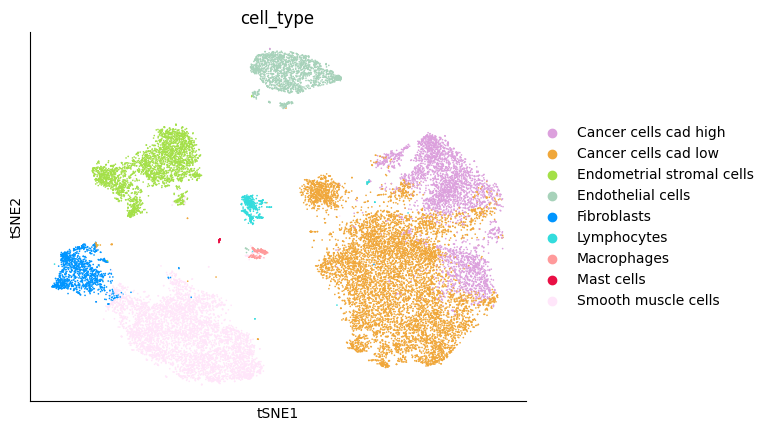

In [260]:
custom_colors = [
    '#dca0dd',
    '#f0a73a',
    '#a4e048',
    '#a7d2ba',
    '#0095ff',
    '#33dcdd',
    '#ff9a9b',
    '#e90f44',
    '#ffe6fa',
    '#32037d',
    '#c2900f'
]
ax = sc.pl.tsne(
    adata,
    color=['cell_type'],
    show=False,
    palette=custom_colors,
    #legend_loc='on data',
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
#plt.tight_layout()
plt.show()

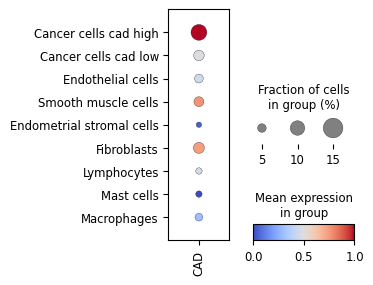

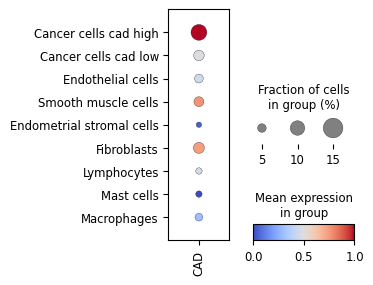

In [262]:
cell_type_list=['Cancer cells cad high','Cancer cells cad low','Endothelial cells','Smooth muscle cells','Endometrial stromal cells','Fibroblasts','Lymphocytes','Mast cells','Macrophages']
adata.obs['cell_type'] = pd.Categorical(
    adata.obs['cell_type'],
    categories=cell_type_list,
    ordered=True
)
fig=sc.pl.dotplot(
    adata,
    'CAD',
    use_raw=False,
    groupby='cell_type',
    standard_scale='var',
    cmap='coolwarm',
    vmax=1,
    vmin=0,
    expression_cutoff=0.3,
    dendrogram=False,
    var_group_labels=None,
    return_fig=True,
    figsize=(2.4,3),
    dot_max=0.15,
)
fig.show()
fig.savefig('cad_dotplot.pdf', format='pdf', bbox_inches='tight',dpi=600)

In [269]:
sc.write('combine_result_out.h5ad', adata)